In [1]:
#import python/ML modules

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [2]:
#load in image data

import os
main_folder = 'Covid19-dataset'
subfolders = ['test', 'train']
#pixel normalizer
training_data_generator = ImageDataGenerator(rescale = 1./255, zoom_range = 0.1, rotation_range = 25, width_shift_range = 0.05, height_shift_range=0.05)
validation_data_generator = ImageDataGenerator()
#set batch size
BATCH_SIZE = 32
#set up generator for training data
training_iterator = training_data_generator.flow_from_directory(directory = os.path.join(main_folder, subfolders[1]), class_mode = 'categorical',color_mode = 'grayscale',batch_size = BATCH_SIZE, classes = ['Covid', 'Normal', 'Viral Pneumonia'])
#set up generator for validation data
validation_iterator = validation_data_generator.flow_from_directory(directory = os.path.join(main_folder, subfolders[0]), class_mode = 'categorical', color_mode = 'grayscale', batch_size = BATCH_SIZE, classes = ['Covid', 'Normal', 'Viral Pneumonia'])

Found 181 images belonging to 3 classes.
Found 46 images belonging to 3 classes.


In [3]:
#creating a classification neural network model

# sequential model
model = Sequential()
# add input layer with grayscale image shape
model.add(tf.keras.Input(shape = (256, 256, 1)))
# convolutional hidden layers with relu functions
# maxpooling layers and dropout layers as well
model.add(layers.Conv2D(5, 5, strides = 3, activation = "relu")) 
model.add(layers.MaxPooling2D(
pool_size = (2, 2), strides = (2,2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(3, 3, strides = 1, activation = "relu")) 
model.add(layers.MaxPooling2D(
pool_size = (2, 2), strides = (2,2)))
model.add(layers.Dropout(0.2))

# experimenting with extra layers
#model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu"))
#model.add(tf.keras.layers.Conv2D(1, 1, strides=1, activation="relu"))
#model.add(tf.keras.layers.Dropout(0.1))

model.add(layers.Flatten())
# output layer with softmax activation function
model.add(layers.Dense(3, activation = "softmax"))
# compile model with Adam optimizer
# loss function is categorical crossentropy
# metrics are categorical accuracy and AUC
print("\nCompiling model...")
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = .001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
# summarize model
model.summary()


Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 5)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 42, 42, 5)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 3)         138       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 3)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 

In [4]:
#test out the model

epochs = 5
early_stopping = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)


history = model.fit(training_iterator, steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs = 5, validation_data = validation_iterator, validation_steps = validation_iterator.samples/BATCH_SIZE, callbacks=[early_stopping])

validation_results = model.evaluate(validation_iterator, steps = validation_iterator.samples/BATCH_SIZE)

print("Validation Loss:", validation_results[0])
print("Validation Categorical Accuracy:", validation_results[1])
print("Validation AUC:", validation_results[2])




Epoch 1/5
5/5 [==============================] - 1s 164ms/step - loss: 1.0347 - categorical_accuracy: 0.4144 - auc: 0.6756 - val_loss: 8.2214 - val_categorical_accuracy: 0.5000 - val_auc: 0.6641
Epoch 2/5
5/5 [==============================] - 1s 111ms/step - loss: 0.8329 - categorical_accuracy: 0.5193 - auc: 0.7605 - val_loss: 46.4709 - val_categorical_accuracy: 0.5652 - val_auc: 0.6739
Epoch 3/5
5/5 [==============================] - 1s 112ms/step - loss: 0.6659 - categorical_accuracy: 0.6354 - auc: 0.8358 - val_loss: 23.2171 - val_categorical_accuracy: 0.5652 - val_auc: 0.6739
Epoch 4/5
5/5 [==============================] - 1s 121ms/step - loss: 0.6215 - categorical_accuracy: 0.6519 - auc: 0.8679 - val_loss: 13.2106 - val_categorical_accuracy: 0.6957 - val_auc: 0.7684
Epoch 5/5
1/1 [==============================] - 0s 38ms/step - loss: 10.5336 - categorical_accuracy: 0.6957 - auc: 0.7977
Validation Loss: 10.533585548400879
Validation Categorical Accuracy: 0.695652186870575
Validat

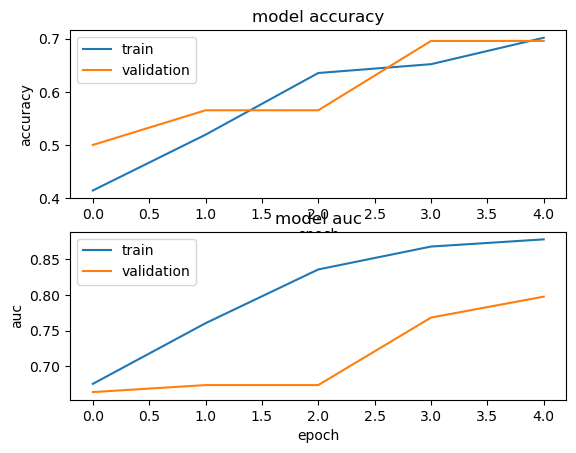

In [6]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

In [7]:
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
report = classification_report(true_classes, predicted_classes)
print(report)   

2/2 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.55      0.85      0.67        26
           1       0.33      0.10      0.15        20

    accuracy                           0.52        46
   macro avg       0.44      0.47      0.41        46
weighted avg       0.46      0.52      0.44        46


In [8]:
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

[[22  4]
 [18  2]]
